In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
from dotenv import load_dotenv
from pyproj import Transformer
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import folium
import cv2
from urban_watch.ml_logic.data import load_data
from s2cloudless import S2PixelCloudDetector
from urban_watch.ml_logic.package import CloudMasker
from urban_watch.ml_logic.package import preprocess_image

/home/k2805/.pyenv/versions/3.10.6/envs/urban_watch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os

In [4]:
load_dotenv()  # charge automatiquement le .env du dossier courant

config = SHConfig()
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")

In [5]:
list_bbox_centers = [(43.52960344286241, 5.448962145567533),
(48.092094070852475, -1.7036876101196967),
 (48.121222106840435, -1.602864906604979),
 (45.74557103359813, 4.803091960652229),
 (47.8776770361181, -3.909947991759771),
 (44.55378060775165, 4.28389205759154),
 (45.69764498502806, 5.8945655967385315),
 (48.07500134978729, 7.3491231648955155),
 (50.63412206750312, 3.0435779303880106),
 (44.83078182200822, 0.5108123933396876)]

In [6]:
from urban_watch.ml_logic.data import make_bbox_global, get_data

data = get_data(list_bbox_centers, config)

📡 Downloading tile 0 at 43.52960344286241,5.448962145567533 ...
✔ Saved tile 0 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_0
📡 Downloading tile 1 at 48.092094070852475,-1.7036876101196967 ...
✔ Saved tile 1 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_1
📡 Downloading tile 2 at 48.121222106840435,-1.602864906604979 ...
✔ Saved tile 2 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_2
📡 Downloading tile 3 at 45.74557103359813,4.803091960652229 ...
✔ Saved tile 3 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_3
📡 Downloading tile 4 at 47.8776770361181,-3.909947991759771 ...
✔ Saved tile 4 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_4
📡 Downloading tile 5 at 44.55378060775165,4.28389205759154 ...
✔ Saved tile 5 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_5
📡 Downloading tile 6 at 45.69764498502806,5.8945655967385315 ...
✔ Saved tile 6 in /home/k2805/c

In [7]:
from urban_watch.ml_logic.data import load_data

X, meta = load_data()
print("shape de x:", X.shape)
print("Nombre de NaN dans X brut :", np.isnan(X).sum())

shape de x: (10, 300, 300, 10)
Nombre de NaN dans X brut : 0


In [8]:
from urban_watch.ml_logic.labels import get_bbox_from_features, bbox_to_wgs84

list_bbox, list_crs = get_bbox_from_features()
list_bbox_wgs84 = bbox_to_wgs84(list_bbox, list_crs)

/home/k2805/.pyenv/versions/3.10.6/envs/urban_watch/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [9]:
from urban_watch.ml_logic.labels import tile_name_from_bbox_wgs84

tile_names = tile_name_from_bbox_wgs84(list_bbox_wgs84)

In [10]:
from urban_watch.ml_logic.labels import get_label_array

results = get_label_array(tile_names, list_bbox_wgs84, list_bbox, list_crs)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Exemple palette simplifiée
colors = [
    "#006400",  # 10 Trees
    "#ffbb22",  # 20 Shrub
    "#ffff4c",  # 30 Grass
    "#f096ff",  # 40 Crop
    "#fa0000",  # 50 Built-up
    "#b4b4b4",  # 60 Bare
    "#f0f0f0",  # 70 Snow
    "#0064c8",  # 80 Water
    "#0096a0",  # 90 Wetlands
    "#00cf75",  # 95 Mangroves
    "#fae6a0"   # 100 Moss/Lichen
]

cmap = ListedColormap(colors)


In [13]:
image = X[6,:,:,:]

B2, B3, B4, B8, B11 = image[:,:,0], image[:,:,1], image[:,:,2], image[:,:,3], image[:,:,4]

# True color (attention : nécessite une normalisation)
RGB = np.dstack([
    B4,
    B3,
    B2
]).astype(float)

# Normalisation 0-1 pour affichage (important !)
RGB = (RGB - RGB.min()) / (RGB.max() - RGB.min() + 1e-6)

# Normalisation par percentiles (évite que quelques pixels lumineux écrasent tout le contraste)
p2 = np.percentile(RGB, 2)
p98 = np.percentile(RGB, 98)

RGB_stretched = np.clip((RGB - p2) / (p98 - p2), 0, 1)

# Correction gamma (0.7–1.0 recommandé)
gamma = 0.8
RGB_corrected = np.clip(RGB_stretched ** gamma, 0, 1)


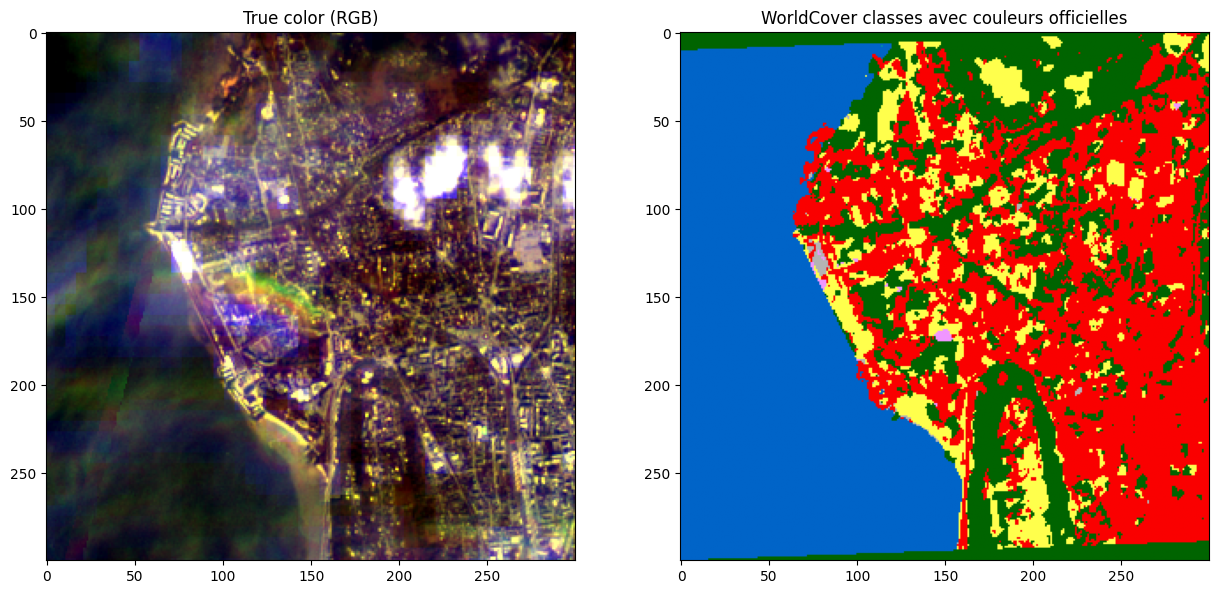

In [14]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plt.imshow(RGB_stretched)
plt.title("True color (RGB)")

plt.subplot(1,2,2)
plt.imshow(results[6], cmap=cmap, vmin=10, vmax=110)
plt.title("WorldCover classes avec couleurs officielles")
plt.show()


debut du test train model avec le Y


In [15]:
y_list =results

In [16]:
y = np.array(y_list)

print("Labels uniques :", np.unique(y))
print("Shape y:", y.shape)

Labels uniques : [ 0 10 20 30 40 50 60 80 90]
Shape y: (10, 300, 300)


In [17]:
X_list = []
y_list = []
for i in range(X.shape[0]):
    img = X[i]
    label = y[i]

    X_processed, mask_valid= preprocess_image(img)

    y_flat = label.reshape(-1)
    y_valid = y_flat[mask_valid.reshape(-1)]

    X_list.append(X_processed)
    y_list.append(y_valid)

X_all = np.vstack(X_list)
y_all = np.hstack(y_list)

print("X_all", X_all.shape)
print("y_all", y_all.shape)
print("nan dans xall", np.isnan(X_all).sum())


X_all (648654, 13)
y_all (648654,)
nan dans xall 0


In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1
)

clf.fit(X_all, y_all)
print("Accuracy :", clf.score(X_all, y_all))

Accuracy : 0.9127161784248613


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.4,
    random_state=42,
    stratify=y_all
)

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc  = clf.score(X_test, y_test)

print("Accuracy train :", train_acc)
print("Accuracy test :", test_acc)

Accuracy train : 0.9869421776398282
Accuracy test : 0.7723443124619405
